In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import multidms
import pickle

import os
from functools import reduce
from itertools import combinations
from collections import defaultdict

from scipy.stats import pearsonr
import numpy as np
import pandas as pd
import jax

from matplotlib.lines import Line2D
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
import matplotlib.patches as patches
import seaborn as sns

%matplotlib inline

In [3]:
# plt.rcParams.keys()

In [4]:
rc_kwargs = {
    'legend.frameon': False,
    "font.size" : 11,
    "font.weight" : "normal"
}

plt.rcParams.update(**rc_kwargs)

In [5]:
OUTDIR = "../results/manuscript_figures/"
if not os.path.exists(OUTDIR): os.mkdir(OUTDIR)

These models were fit with [this version](https://github.com/matsengrp/multidms/commit/4c88f16a13bc910f30aea0394da70373ea87e8e6) of multidms - and thus in the future if the object SHA changes in newer versions pickle binaries will not load unless rolled back to this version

In [6]:
model_set = "../results/model-ch-sig-I-act"
# model_set = "../results/ch_collapsed_barcodes/"
models = pickle.load(open(f"{model_set}/models.pkl", "rb"))
models.head()

,dataset,δ_huber,scale_coeff_lasso_shift,scale_coeff_ridge_beta,scale_coeff_ridge_shift,scale_coeff_ridge_gamma,scale_coeff_ridge_ch,data_idx,epistatic_model,output_activation,...,init_beta_naught,warmup_beta,tol,num_training_steps,iterations_per_step,save_model_at,PRNGKey,step_loss,model_30000,replicate
0,<multidms.data.Data object at 0x7f4ead...,1,0.0,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.944888810776554, 0.8002181582519432, 0.7401...",<multidms.model.Model object at 0x7f4e...,0
1,<multidms.data.Data object at 0x7f4e24...,1,0.0,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9380562301362928, 0.7859858644923466, 0.719...",<multidms.model.Model object at 0x7f4c...,1
2,<multidms.data.Data object at 0x7f4ead...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9449509844610131, 0.801543010059766, 0.7403...",<multidms.model.Model object at 0x7f4c...,0
3,<multidms.data.Data object at 0x7f4e24...,1,0.000001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.939339875770355, 0.7871014657254978, 0.7222...",<multidms.model.Model object at 0x7f4c...,1
4,<multidms.data.Data object at 0x7f4ead...,1,0.00001,0,0,0.001,0.001,0,Sigmoid,Identity,...,0.0,False,0.0001,30,1000,[30000],0,"[0.9590313547627343, 0.8144916915121373, 0.757...",<multidms.model.Model object at 0x7f4c...,0


**Note** When evaluting inferred parameters from these model fits we choose a "times seen threshold" which is essentially the number of genetic backgrounds a mutation must be seen in across all experimental conditions within a single model fit

In [7]:
# Seen at least once in each homolog
times_seen_threshold = 1

In [8]:
# The column name in the models df above denoting where the binary model is saved
model_name = "model_30000"

In [9]:
# The chosen lasso weight for optimal results
chosen_model_penalty = 5e-5

**Note** We will merge the param results from replicate fits for the chosen model penalty. By choosing `how = 'outer'` We keep all mutations from both replicates so long as they each satify the times seen threshold in their respective fit. This means there will be some missing data on both sides

In [10]:
# chosen_replicate_models = models.query("scale_coeff_lasso_shift == @chosen_model_penalty")
# mut_df_replicates = multidms.utils.combine_replicate_muts(
#     {
#         row.replicate:row[model_name] for idx, row in chosen_replicate_models.iterrows()
#     },
#     times_seen_threshold=times_seen_threshold,
#     how="outer"
# )
# mut_df_replicates.head()

## Convergence Analysis

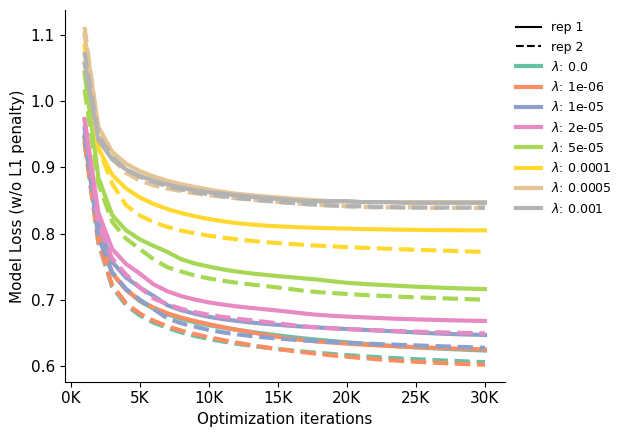

In [11]:
saveas="convergence_all_lasso_lines"
cmap=plt.get_cmap("Set2")


fig, ax = plt.subplots(1,figsize=[6.4,4.5])
color_idx = -1
for i, (model, model_row) in enumerate(models.iterrows()):
    if i%2 == 0: color_idx += 1

    ax.plot(
        [1000 * (s+1) for s in range(len(model_row.step_loss))],
        model_row.step_loss,
        c=cmap.colors[color_idx],
        lw=3,
        linestyle="-" if model_row.replicate == 0 else "--",
        label=f"rep: {model_row.replicate} scale_coeff: {model_row.scale_coeff_lasso_shift}"
    )
# labels = ax.get_xticklabels()[1:-1]
# print(labels)
# lebels = [f"{int(l)//1000}K" for l in labels]
ticks = range(0, 30001, 5000)
labels = [f"{t//1000}K" for t in ticks]
ax.set_xticks(ticks, labels, rotation=0, ha='center')
ax.set_ylabel("Model Loss (w/o L1 penalty)")
ax.set_xlabel("Optimization iterations")

black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=5,
        linewidth=3,
        label="$\lambda$: "+str(lasso)
    )
    for lasso, color in zip(models.scale_coeff_lasso_shift.unique(), cmap.colors)
]

elements = [black_line, black_dashed] + lasso_color_handles
ax.legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)
sns.despine(ax=ax)

# fig.suptitle("Replicate Fit Convergence")
plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

## Shrinkage Analysis

In [12]:
tall_mut_df = pd.DataFrame()
for replicate, rep_models in models.groupby("replicate"):
    fit_dict = {f"l_{float(row.scale_coeff_lasso_shift)}":row[model_name] for _, row in rep_models.iterrows()}
    
    
    mut_df = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    mut_df.rename(
        {
            bc : f"{bc}_Omicron_BA1"
            for bc in mut_df.columns
            if "beta" in bc
        }, 
        axis=1, 
        inplace=True
    )

    mut_df = pd.melt(
        mut_df.reset_index(), 
        id_vars=["mutation"],
        value_vars=[
            col for col in mut_df.columns 
            if ("_S_" in col or "beta" in col) and "avg" not in col
        ],
        value_name="S"
    )
    
    mut_df = mut_df.assign(
        scale_coeff_lasso=[ 
            v.split("_")[1]
            for v in mut_df.variable
        ],
        sense=[
            "stop" if "*" in mut else "nonsynonymous"
            for mut in mut_df.mutation
        ],
        condition=[
            "_".join(v.split("_")[3:])
            for v in mut_df.variable
        ],
        replicate=replicate
    )
    
    mut_df.drop("variable", axis=1, inplace=True)
    tall_mut_df = pd.concat([tall_mut_df, mut_df])
    
tall_mut_df

,mutation,S,scale_coeff_lasso,sense,condition,replicate
0,M1I,-3.260941,0.0,nonsynonymous,Omicron_BA1,0
1,F2I,0.122912,0.0,nonsynonymous,Omicron_BA1,0
2,F2L,0.470533,0.0,nonsynonymous,Omicron_BA1,0
3,F2S,0.258484,0.0,nonsynonymous,Omicron_BA1,0
4,F2V,0.920090,0.0,nonsynonymous,Omicron_BA1,0
...,...,...,...,...,...,...
155419,S1252T,-0.000000,0.001,nonsynonymous,Omicron_BA2,1
155420,S1252V,-0.000000,0.001,nonsynonymous,Omicron_BA2,1
155421,S1252W,-0.000000,0.001,nonsynonymous,Omicron_BA2,1
155422,S1252Y,-0.000000,0.001,nonsynonymous,Omicron_BA2,1


In [13]:
def loss(model, condition):
    kwargs = {
        'scale_coeff_ridge_beta': 0.,
        'scale_coeff_ridge_shift': 0.,
        'scale_coeff_ridge_gamma': 0.
    }
    
    data = (
        {condition:model.data.training_data["X"][condition]}, 
        {condition:model.data.training_data["y"][condition]}
    )
    
    params = model.get_condition_params(condition)
    return jax.jit(model._model_components["objective"])(model.params, data)

lasso_sparsity_loss = defaultdict(list)
for lasso, lasso_replicates in models.groupby("scale_coeff_lasso_shift"):
    lasso_sparsity_loss["lasso"].append(str(lasso))
    fit_dict = {}
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        replicate = row.replicate
        fit_dict[f"{replicate}"] = model

    muts_df_outer = multidms.utils.combine_replicate_muts(
        fit_dict, 
        times_seen_threshold=times_seen_threshold, 
        how="outer"
    )
    muts_df_outer = muts_df_outer.assign(
        sense = [
            "stop" if "*" in mut else "nonsynonymous"
            for mut in muts_df_outer.index.values
        ]
    )

    muts_df_inner = muts_df_outer.dropna()
    
    # plot corr by sparsity
    for cond in model.data.conditions:
        if cond == model.data.reference:
            

            if np.all(muts_df_inner[f"0_beta"] <= 0.05) or np.all(muts_df_inner[f"1_beta"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_beta"], muts_df_inner[f"1_beta"])
                r = corr[0]
                interval = corr.confidence_interval()
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                    tuple[(interval.low, interval.high)]
                )

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_beta", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_beta"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            

        else:
            if np.all(muts_df_inner[f"0_S_{cond}"] <= 0.05) or np.all(muts_df_inner[f"1_S_{cond}"] <= 0.05):
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(np.nan)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(np.nan)
            else:
                corr = pearsonr(muts_df_inner[f"0_S_{cond}"], muts_df_inner[f"1_S_{cond}"])
                r = corr[0]
                interval = corr.confidence_interval()
                lasso_sparsity_loss[f"{cond}-replicate-correlation"].append(r)
                lasso_sparsity_loss[f"{cond}-replicate-correlation-interval"].append(
                    tuple[(interval.low, interval.high)]
                )

            for rep, marker in zip([0,1], ["o", "D"]):
                rep_cond_shifts = muts_df_outer[[f"{rep}_S_{cond}", "sense"]].dropna()
                for sense, color in zip(["stop", "nonsynonymous"], ["red", "blue"]):
                    shifts = rep_cond_shifts.query("sense == @sense")[f"{rep}_S_{cond}"]
                    sparsity = (len(shifts[shifts==0]) / len(shifts))*100
                    lasso_sparsity_loss[f"{cond}-{rep}-{sense}-sparsity"].append(sparsity)
            
    # plot loss 
    for _, row in lasso_replicates.iterrows():
        model = row[model_name]
        rep = row.replicate
        for cond in model.data.conditions:
#             if cond == model.data.reference: continue
            lasso_sparsity_loss[f"{cond}-{rep}-loss"].append(loss(model, cond))

lasso_sparsity_loss = pd.DataFrame(lasso_sparsity_loss)
lasso_sparsity_loss

,lasso,Delta-replicate-correlation,Delta-replicate-correlation-interval,Delta-0-stop-sparsity,Delta-0-nonsynonymous-sparsity,Delta-1-stop-sparsity,Delta-1-nonsynonymous-sparsity,Omicron_BA1-replicate-correlation,Omicron_BA1-replicate-correlation-interval,Omicron_BA1-0-stop-sparsity,...,Omicron_BA2-0-stop-sparsity,Omicron_BA2-0-nonsynonymous-sparsity,Omicron_BA2-1-stop-sparsity,Omicron_BA2-1-nonsynonymous-sparsity,Delta-0-loss,Omicron_BA1-0-loss,Omicron_BA2-0-loss,Delta-1-loss,Omicron_BA1-1-loss,Omicron_BA2-1-loss
0,0.0,0.554929,"tuple[0.5370964978985913, 0.5722648986501958]",0.000000,0.000000,0.000000,0.000000,0.930213,"tuple[0.9267077900747744, 0.9335555876422115]",0.0,...,0.000000,0.000000,0.000000,0.000000,0.20882076205032926,0.22789180399101802,0.18664733664308814,0.24506442143971266,0.18465566536826694,0.1760694236269004
1,1e-06,0.573597,"tuple[0.5562993136440083, 0.5903975753688284]",1.058201,1.062118,2.358491,1.612388,0.931465,"tuple[0.9280207702838509, 0.9347500486742599]",0.0,...,2.645503,2.043772,3.301887,2.538314,0.2095801899892468,0.2280875893955353,0.18732690364137838,0.24470831892525705,0.18108420346631426,0.17597020957958107
2,1e-05,0.664096,"tuple[0.6496527952209529, 0.6780609364839632]",42.857143,14.531703,36.792453,15.692848,0.931760,"tuple[0.9283298103293437, 0.9350311703975887]",0.0,...,54.497354,22.610235,55.188679,21.695402,0.21712778568637822,0.23531437758381926,0.19444945622000653,0.25432472750856117,0.18987429899848507,0.18334323651068807
3,2e-05,0.692708,"tuple[0.6792574701745838, 0.7056933606407964]",79.894180,25.474734,73.113208,26.963602,0.927198,"tuple[0.9235476681576391, 0.930680097702718]",0.0,...,87.301587,39.588027,87.735849,38.074713,0.22445927747438593,0.2425961013490243,0.2009668408180894,0.26299422961432173,0.1969208688038345,0.1893664938717848
4,5e-05,0.699526,"tuple[0.6863186029652781, 0.7122722270788485]",97.883598,48.181526,96.698113,49.568966,0.917820,"tuple[0.9137205688259998, 0.9217324894906378]",0.0,...,99.470899,64.435146,99.528302,62.021073,0.24213011826465483,0.2611316537893592,0.21288153288295714,0.2837855560280358,0.2162351184540399,0.20015619585673422
5,0.0001,0.670030,"tuple[0.6557884109130815, 0.6837944044772347]",100.000000,91.422594,100.000000,83.205619,0.915030,"tuple[0.9107982279932924, 0.9190700416444924]",0.0,...,100.000000,93.723849,100.000000,87.915070,0.27705877098966536,0.2971002289750148,0.2308249931522797,0.30993203770406796,0.2466480885122338,0.21583642158484584
6,0.0005,NaN,NaN,100.000000,100.000000,100.000000,100.000000,0.910136,"tuple[0.9056726147263224, 0.9143984410059197]",0.0,...,100.000000,99.983907,100.000000,99.984036,0.29546649983190093,0.30793628224864517,0.24423537588069633,0.3353658149276702,0.2663713488090842,0.23718472964055182
7,0.001,NaN,NaN,100.000000,100.000000,100.000000,100.000000,0.909570,"tuple[0.9050797701373341, 0.9138579589552435]",0.0,...,100.000000,100.000000,100.000000,100.000000,0.2952379991468209,0.30723660253500723,0.2440551118693834,0.3357127147863087,0.2663125506383004,0.23733334115837154


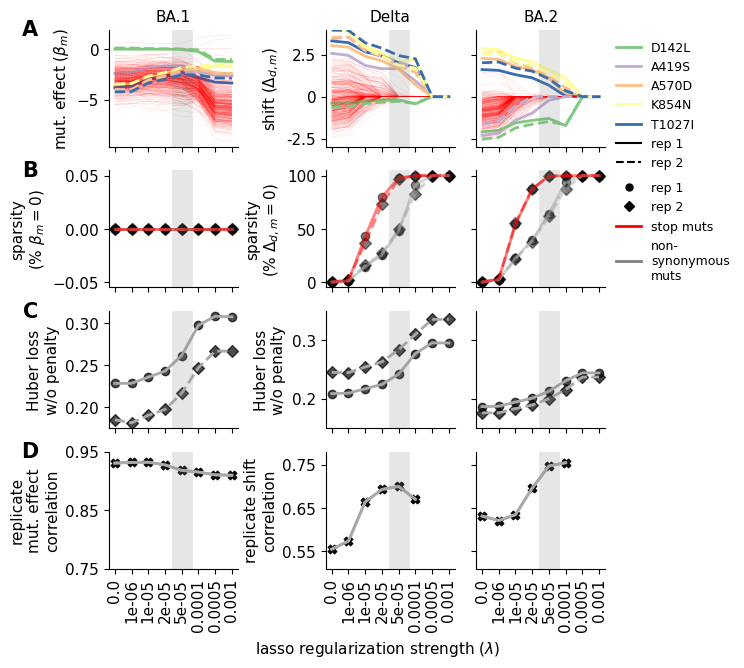

In [15]:
# call percent - > "fraction"
# Change lambda to whatever we decide for the lexicon

saveas="shrinkage_analysis_trace_plots_beta"
fig, ax = plt.subplots(
    4,4, 
    figsize=[6.4,7],
    sharex=True, 
#     sharey='row',
    gridspec_kw={
        'width_ratios': [1,0.35,1,1]
#         'height_ratios' : []
    }
)

lasso_cmap=plt.get_cmap("Set2").colors
lasso_shrinkage = sorted(models.scale_coeff_lasso_shift.unique())
lasso_shrinkage_cmap = dict(zip(lasso_shrinkage, lasso_cmap))

mutations_to_highlight = ["D142L", "A419S", "A570D", "K854N", "T1027I"]
mutations_cmap=plt.get_cmap("Accent").colors
mutations_cmap = dict(zip(mutations_to_highlight, mutations_cmap))

condition_col = {
    "Omicron_BA1" : 0,
    "Delta" : 2,
    "Omicron_BA2" : 3
}

replicate_line_style = {
    0 : "-",
    1 : "--"
}

replicate_marker = {
    0 : "o",
    1 : "D"
}

sense_colors = {
    "nonsynonymous" : "darkgrey",
    "stop" : "red"
}

sense_lw = {
    "nonsynonymous" : 0.5,
    "stop" : 0.1
}

sense_alpha = {
    "nonsynonymous" : 0.1,
    "stop" : 0.5
}

model_choice = 5e-5
model_line_kwargs = {
    "linewidth" : 15,
    "color" : "grey",
    "alpha" : 0.1
}

for (condition, replicate), df in tall_mut_df.groupby(["condition", "replicate"]):
    row = 0
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
#     # plot nonsynonymous, non validated
#     for mut, trace_df in df.query(
#         "sense == 'nonsynonymous' & not mutation.isin(@mutations_to_highlight)"
#     ).groupby("mutation"):
#         iter_ax.plot(
#             trace_df.scale_coeff_lasso, 
#             trace_df.S,
#             linestyle=replicate_line_style[replicate],
#             linewidth=sense_alpha['nonsynonymous'],
#             alpha=sense_alpha['nonsynonymous'],
#             color="lightgrey"
#         )
    
    # plot stop traces
    for mut, trace_df in df.query("sense == 'stop'").groupby("mutation"):

        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=sense_lw['stop'],
            alpha=sense_alpha['stop'],
            color=sense_colors['stop']
        )

    # plot highlighted muts
    for mut, trace_df in df.query(
        "mutation.isin(@mutations_to_highlight)"
    ).groupby("mutation"):
        iter_ax.plot(
            trace_df.scale_coeff_lasso, 
            trace_df.S,
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=1.0,
            color=mutations_cmap[mut]
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
        
    # Plot sparsity    
    row = 1
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    for sense in ["nonsynonymous", "stop"]:
        iter_ax.plot(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            linestyle=replicate_line_style[replicate],
            linewidth=2,
            alpha=0.5,
            color=sense_colors[sense]
        )
        
        iter_ax.scatter(
            lasso_sparsity_loss["lasso"],
            lasso_sparsity_loss[f"{condition}-{replicate}-{sense}-sparsity"],
            marker=replicate_marker[replicate],
            alpha=0.5,
            color="black"
        )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
        
    # Plot Loss  
    row = 2
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        linestyle=replicate_line_style[replicate],
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )

    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-{replicate}-loss"],
        marker=replicate_marker[replicate],
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)
    
    # Plot Correlation  
    row = 3
    iter_ax = ax[row, condition_col[condition]]
    sns.despine(ax=iter_ax)
    
    iter_ax.plot(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        linestyle="-",
        linewidth=2,
        alpha=1.0,
        color="darkgrey"
    )
    
    iter_ax.scatter(
        lasso_sparsity_loss["lasso"],
        lasso_sparsity_loss[f"{condition}-replicate-correlation"],
        marker="X",
        alpha=0.7,
        color="black"
    )
    iter_ax.axvline(str(model_choice), **model_line_kwargs)



ax[0, 0].set_title(r"BA.1", size=11)
ax[0, 2].set_title("Delta", size=11)
ax[0, 3].set_title("BA.2", size=11)

ax[0, 1].set_visible(False)
ax[1, 1].set_visible(False)
ax[2, 1].set_visible(False)
ax[3, 1].set_visible(False)

ax[0, 0].set_ylabel("mut. effect ($beta_{m}$)", size=11)
ax[1, 0].set_ylabel("sparsity\n(% $beta_{m} = 0$)", size=11)
# ax[2, 0].set_ylabel("condition\n train data loss \n$L_{Huber_{\sigma=1}}^{d}$ w/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)
ax[2, 0].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[3, 0].set_ylabel("$r(beta_{m}^{rep1},beta_{m}^{rep2})$", size=11)
ax[3, 0].set_ylabel("replicate\nmut. effect\ncorrelation", size=11)

ax[0, 2].set_ylabel("shift $(\Delta_{d,m})$", size=11)
ax[1, 2].set_ylabel("sparsity\n(% $\Delta_{d,m} = 0$)", size=11)
# ax[2, 2].set_ylabel("Huber loss\n w/o penalty", size=11)
ax[2, 2].set_ylabel("Huber loss\nw/o penalty", size=11)
# ax[2, 0].set_ylabel("condition\n training data loss", size=11)

# ax[3, 2].set_ylabel("$r(\Delta_{d,m}^{rep1},\Delta_{d,m}^{rep2})$", size=11)
ax[3, 2].set_ylabel("replicate shift\ncorrelation", size=11)

# TODO legends
black_line = mlines.Line2D([], [], color='black', linestyle='-',
                          markersize=5, label='rep 1')
black_dashed = mlines.Line2D([], [], color='black',linestyle='--',
                          markersize=5, label='rep 2')
lasso_color_handles = [
    mlines.Line2D(
        [], [], 
        color=color, 
        linestyle='-',
        markersize=2,
        linewidth=2,
        label=mut
    )
    for mut, color in mutations_cmap.items()
]

elements = lasso_color_handles + [black_line, black_dashed] 
ax[0,3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                          markersize=5, label='rep 1')
black_triangle = mlines.Line2D([], [], color='black', marker='D', linestyle='None',
                          markersize=5, label='rep 2')

red_line = mlines.Line2D([], [], color='red', linewidth=2,linestyle='-',markersize=5, label='stop muts')
grey_line = mlines.Line2D([], [], color='grey',linewidth=2, linestyle='-',markersize=5, label='non-\nsynonymous\nmuts')

elements = [black_circle, black_triangle, red_line, grey_line] #+lasso_color_handles
ax[1, 3].legend(handles=elements, bbox_to_anchor = (1, 1), loc='upper left', frameon=False, fontsize=9)

ax[3,0].set_xticks(ax[3,0].get_xticks(), ax[3,0].get_xticklabels(), rotation=90, ha='center')
ax[3,2].set_xticks(ax[3,2].get_xticks(), ax[3,2].get_xticklabels(), rotation=90, ha='center')
ax[3,3].set_xticks(ax[3,3].get_xticks(), ax[3,3].get_xticklabels(), rotation=90, ha='center')

ax[3,2].set_xlabel(f"lasso regularization strength ($\lambda$)")
ax[3,2].xaxis.set_label_coords(0.4, -0.6)

ax[0,0].text(
    -0.55, 1.00, 
    f"A", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[0,0].transAxes
)
ax[1,0].text(
    -0.55, 1.00, 
    f"B", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[1,0].transAxes
)
ax[2,0].text(
    -0.55, 1.00, 
    f"C", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[2,0].transAxes
)
ax[3,0].text(
    -0.55, 1.00, 
    f"D", 
    ha="right", va="center", 
    size=15,
    weight="bold",
    transform=ax[3,0].transAxes
)

ax[0, 2].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
ax[0, 2].set_ylim([-3.0, 4])
ax[0, 3].set_yticks([-2.5, 0, 2.5], [-2.5, 0, 2.5])
ax[0, 3].set_ylim([-3.0, 4])
ax[0, 3].yaxis.set_tick_params(labelleft=False)

ax[1, 2].set_yticks([0, 50, 100], [0, 50, 100])
ax[1, 2].set_ylim([-5, 105])
ax[1, 3].set_yticks([0, 50, 100], [0, 50, 100])
ax[1, 3].set_ylim([-5, 105])
ax[1, 3].yaxis.set_tick_params(labelleft=False)

ax[2, 2].set_yticks([.1, .2, .3], [.1, .2, .3])
ax[2, 2].set_ylim([.15, .35])
ax[2, 3].set_yticks([.1, .2, .3], [.1, .2, .3])
ax[2, 3].set_ylim([.15, .35])
ax[2, 3].yaxis.set_tick_params(labelleft=False)

ax[3, 2].set_yticks([.55, .65, .75], [.55, .65, .75])
ax[3, 2].set_ylim([.51, .78])
ax[3, 3].set_yticks([.55, .65, .75], [.55, .65, .75])
ax[3, 3].set_ylim([.51, .78])
ax[3, 3].yaxis.set_tick_params(labelleft=False)

ax[3, 0].set_yticks([.75, .85, .95], [.75, .85, .95])

# plt.tight_layout()
fig.savefig(f"{OUTDIR}/{saveas}.pdf",bbox_inches='tight')
fig.savefig(f"{OUTDIR}/{saveas}.png",bbox_inches='tight')
plt.show()

In [ ]:
# fix labels
# titles = mut effect in BA.1, Delta Shift, BA.2 Shift
# ylabel just math